In [1]:
import sys
import os
sys.path.append('../..')
sys.path


['/opt/anaconda/envs/diffLIME/lib/python39.zip',
 '/opt/anaconda/envs/diffLIME/lib/python3.9',
 '/opt/anaconda/envs/diffLIME/lib/python3.9/lib-dynload',
 '',
 '/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages',
 '/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/setuptools/_vendor',
 '../..']

In [2]:
import tensorflow as tf
tf.__version__, tf.config.get_visible_devices()

2024-12-21 17:08:55.574624: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734797336.350522    2330 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734797336.476156    2330 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-21 17:08:57.567393: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


('2.18.0',
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
  PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')])

In [3]:
import tensorflow as tf
from phmd import datasets
import numpy as np
from phm_framework.data import meta
from phm_framework.nets.dpm  import DiffusionModel
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.cluster import KMeans
from tslearn.metrics import dtw
from scipy.signal import correlate
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt


/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [4]:
ds = datasets.Dataset("CWRU")
task = ds['fault']
sets = task[0]

Dataset CWRU already downloaded and extracted
Remember to cite the original publisher dataset:
	@misc{caseBearingData,
		author = {},
		title = {{B}earing {D}ata {C}enter | {C}ase {S}chool of {E}ngineering | {C}ase {W}estern {R}eserve {U}niversity --- engineering.case.edu},
		howpublished = {\url{https://engineering.case.edu/bearingdatacenter}},
		year = {},
		note = {[Accessed 08-04-2024]},
	}
You can download the dataset manually from:  https://engineering.case.edu/bearingdatacenter

** If you find this tool useful, please cite our SoftwareX paper.



Reading data: 100%|██████████| 161/161 [00:09<00:00, 16.18it/s]
INFO:root:Read in 13.903834104537964 seconds
INFO:root:It is possible stratified split? True
/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: DE,unit,fault
INFO:root:Train shape: (28567988, 3)
INFO:root:Val shape: (7804030, 3)
INFO:root:Test shape: (979629, 3)


In [5]:
from phm_framework.data import prepare_data

X_train, M_train, Y_train = prepare_data(sets['train'], 'DE', subsignal_length=128, signal_max_length=20000)
_mmin, _mmax = M_train.min(axis=0), M_train.max(axis=0)


X_val, M_val, Y_val = prepare_data(sets['val'], 'DE', subsignal_length=128, signal_max_length=20000)



INFO:root:Meta-attributes extracted in 22.056010246276855 seconds
INFO:root:Meta-attributes extracted in 5.755634546279907 seconds


In [198]:
from phm_framework.data import synthetic
from importlib import reload
reload(synthetic)

(X, E, M), (centroids, stds, kmeans) = synthetic.generate_synth_data(X_train, N=100000)    

/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


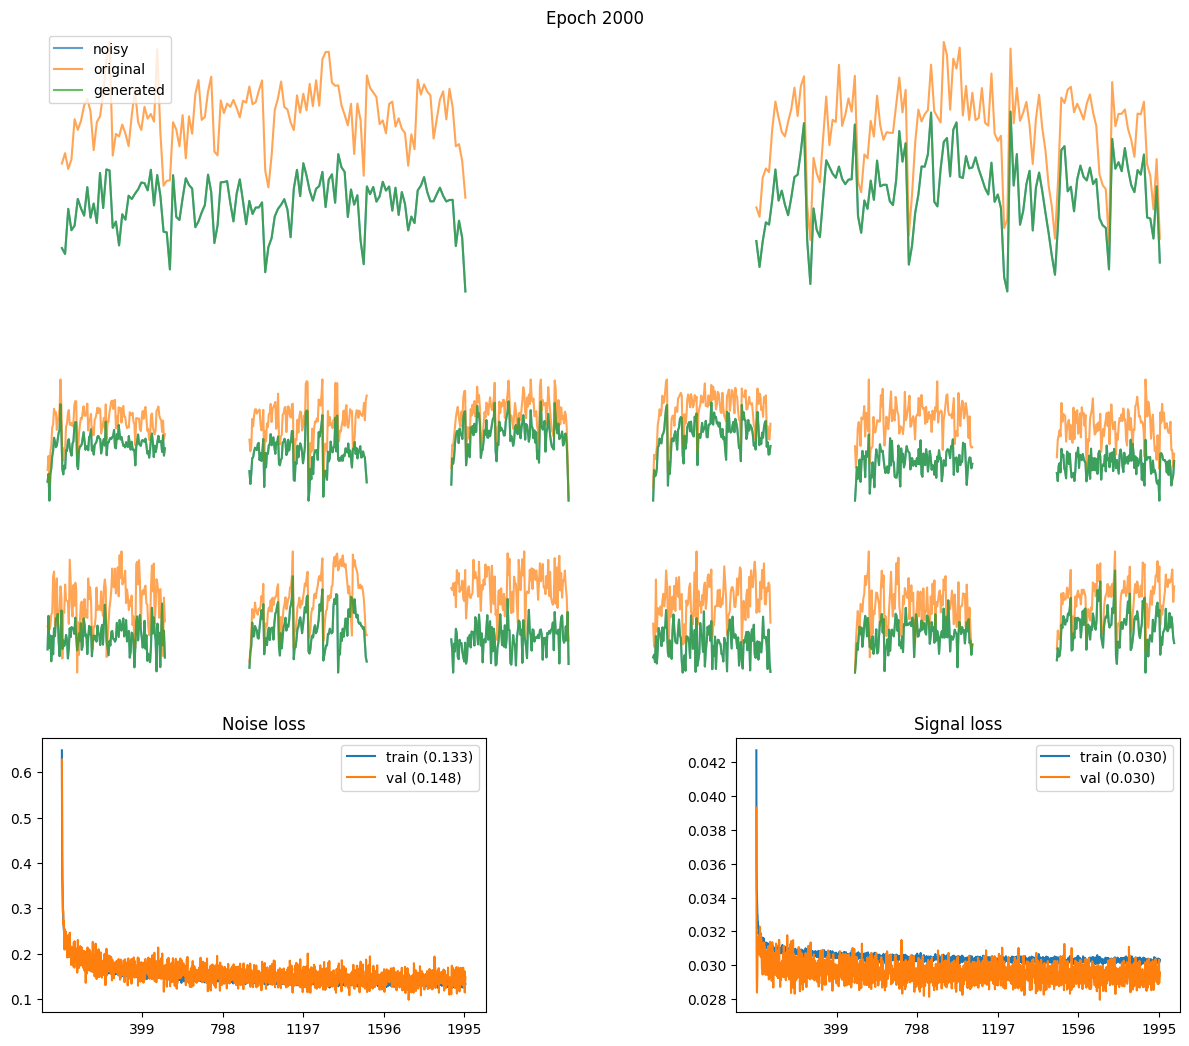

100/100 - 7s - 68ms/step - noise_loss: 0.1334 - signal_loss: 0.0303 - val_noise_loss: 0.1484 - val_signal_loss: 0.0296


In [199]:
from phm_framework.nets import dpm 
reload(dpm)

meta_att = ['periodicity', 'stability', 'oscilation', 'complexity', 'noise', 'informative', 'variability',
            'standard_deviation', 'peculiarity', 'dynamic_range', 'simetry', 'peaks', 'slope', 'f1', 'f2', 'f3']

meta_att = [f"att{i}" for i in range(M.shape[1])]

model = dpm.DiffusionModel(X.shape[1],
                     widths=[32, 64, 64, 32, 32, 32],
                     block_depth=3,
                     num_features=len(meta_att),
                     timesteps=20,
                     cond=True,
                     envelopes=True,
                     feature_names=meta_att,
                     feature_loss_net=False,
                     feature_loss=False)



model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=1e-5
    ),
    loss=tf.keras.losses.MeanAbsoluteError(),
    run_eagerly=False
)

es = tf.keras.callbacks.EarlyStopping(monitor='val_signal_loss', patience=8)

plot_idxs = np.random.uniform(0, X.shape[0], 14).astype(int)

def plotting(*args, **kwargs):
    return model.plot_images(np.expand_dims(X[plot_idxs], axis=-1), 
                             np.moveaxis(E[plot_idxs], -1, -2),
                             np.expand_dims(M[plot_idxs], axis=-1), 
                           *args, **kwargs)

pi = tf.keras.callbacks.LambdaCallback(on_epoch_end=plotting),
                

model.fit(
    (np.expand_dims(X, axis=-1), 
     np.moveaxis(E, -1, -2), 
     np.expand_dims(M, axis=-1)),
    epochs=2000,
    batch_size=32,
    steps_per_epoch=100,
    verbose=2,
    validation_data=(np.expand_dims(X, axis=-1)[:128], 
                     np.moveaxis(E[:128], -1, -2), 
                     np.expand_dims(M, axis=-1)[:128]),
    callbacks=[pi]
)



In [201]:
model.network.save('DPM_v1.h5')

In [215]:
X_train[0].shape, centroids.shape

((128,), (10, 2, 128))

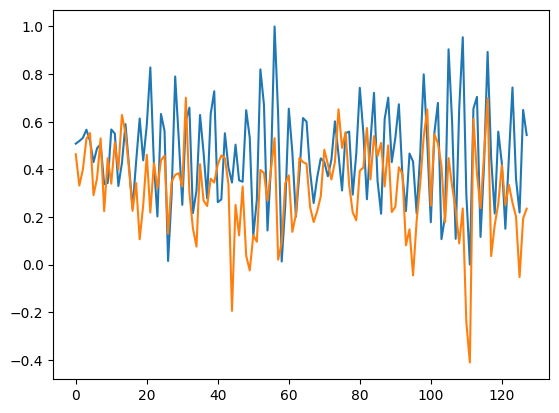

In [265]:
from phm_framework.data import synthetic
from importlib import reload
reload(synthetic)

s = X_train[100]
    
sn = synthetic.generate_synthetic_from_dpm(s, model, centroids)


plt.plot(s)
plt.plot(sn)

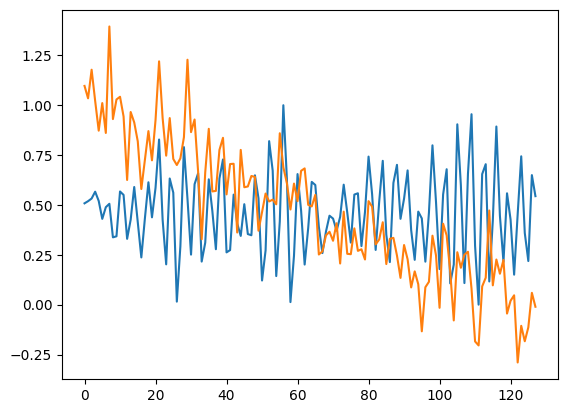

In [280]:
from phm_framework.data import synthetic
from importlib import reload
reload(synthetic)

s = X_train[100]
f = generate_meta(s, centroids)

f[-5] = -0.05

sn = synthetic.generate_synthetic_from_dpm(s, model, centroids, forced_features=f)


plt.plot(s)
plt.plot(sn)

/tmp/ipykernel_2330/1648391898.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")


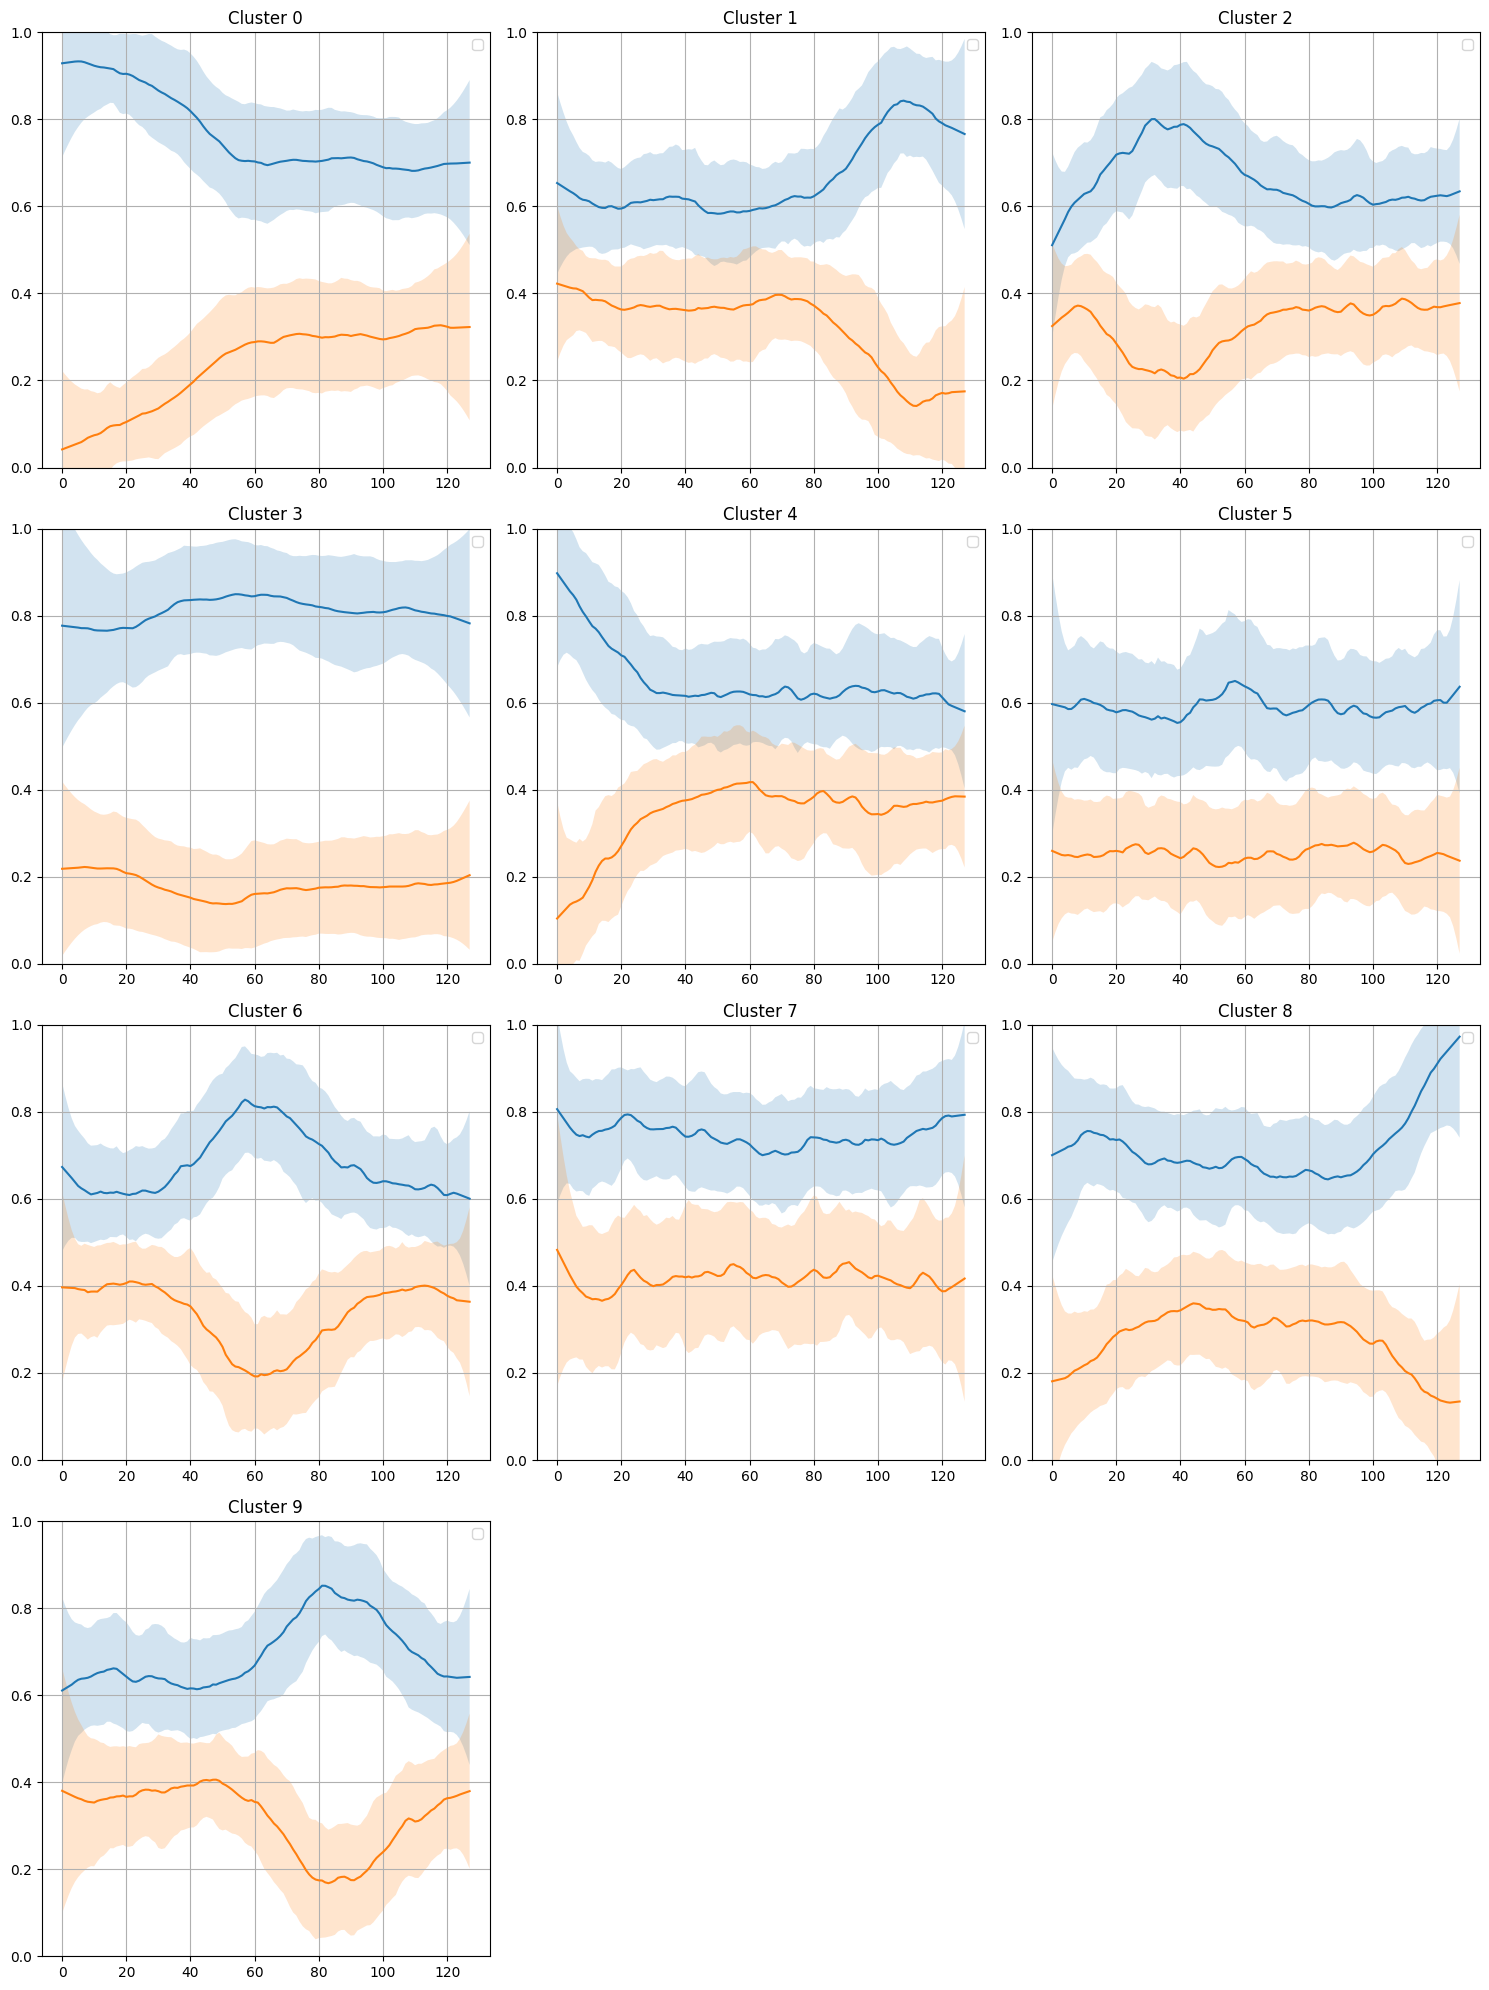

In [164]:
def plot_clusters(series_temporales, labels, centroids, stds, n_clusters):
    """
    Dibuja los clusters con una cuadrícula de 3 columnas y N filas.

    Args:
        series_temporales (numpy.ndarray): Array de series temporales.
        labels (numpy.ndarray): Etiquetas de los clusters.
        centroids (numpy.ndarray): Centroides de los clusters.
        n_clusters (int): Número de clusters.
    """
    # Determinar el número de filas y columnas
    n_cols = 3
    n_rows = int(np.ceil(n_clusters / n_cols))

    plt.figure(figsize=(15, n_rows * 5))  # Ajustar tamaño según filas

    for cluster_idx in range(n_clusters):
        plt.subplot(n_rows, n_cols, cluster_idx + 1)  # Configurar subplot

        s = centroids[cluster_idx, 0, :]
        std = stds[cluster_idx, 0, :]
        plt.plot(s)
        plt.fill_between(np.arange(s.shape[0]), s-std, s+std, alpha=0.2)

        s = centroids[cluster_idx, 1, :]
        std = stds[cluster_idx, 1, :]
        plt.plot(s)
        plt.fill_between(np.arange(s.shape[0]), s-std, s+std, alpha=0.2)

        plt.title(f"Cluster {cluster_idx}")
        plt.ylim(0, 1)
        plt.legend(loc="upper right")
        plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_clusters(None, None, centroids, stds, 10)

In [173]:
np.where(M[:, -1] == 0)

(array([    9,    10,    13, ..., 99974, 99988, 99991]),)

In [168]:
[:, -1]

array([[-0.0155027 ,  0.12593378,  0.05589072, ...,  0.07774778,
         0.08886373, -0.04942318],
       [ 0.41970805,  0.43898288,  0.47335632, ...,  0.35606897,
         0.52134241,  0.34394879],
       [ 0.256245  ,  0.53657618,  0.39809457, ...,  0.06820669,
         0.09933345,  0.18676981],
       ...,
       [ 0.36290259,  0.45894446,  0.33391497, ...,  0.4239254 ,
         0.30247675,  0.23754313],
       [ 0.40440806,  0.34734933,  0.36523792, ...,  0.56448452,
         0.20894418,  0.17008768],
       [ 0.50069569,  0.33489507,  0.26532746, ...,  0.47273054,
         0.40306507,  0.61061469]])

In [169]:
E.shape

(100000, 2, 128)